# Exercise worksheet no 7

# Causal inference

*Machine learning in climate and environmental sciences, winter semester 2023, Jun.-Prof. Peer Nowack, peer.nowack@kit.edu*

*Chair for AI in Climate and Environmental Sciences, https://ki-klima.iti.kit.edu*

**Learning objectives:** As part of this exercise, you will practice a few fundamentals of causal inference, with a focus on time series data. For this, you will use the PCMCI method mentioned in the lecture. For more background on PCMCI and additional tutorials, see its [documentation website](https://github.com/jakobrunge/tigramite) and the original PCMCI publication [Runge et al. Science Advances (2019)](https://www.science.org/doi/10.1126/sciadv.aau4996). There, you will also find information on the causal inference Python package `tigramite`, which you will use for running PCMCI and for visualizing its results.

**Credits:** This worksheet is based on/inspired by a range of `tigramite` tutorials designed by Prof. Dr. Jakob Runge (DLR, TU Dresden) and his team. In addition, it draws on the following paper: [Nowack et al. Nature Communications (2020)](https://www.nature.com/articles/s41467-020-15195-y).




## Installation instructions

To use PCMCI and `tigramite`, first create a new Python environment called `ML-climate-causal` and add it as a kernel to Jupyter.

For this, follow again the instructions for installing a kernel (cf. Assignment 1). 

In essence, in a conda shell/Linux terminal/or similar, type the following sequence of commands (confirm all inquiries with `y`):

`conda create -n ML-climate-causal python=3.10`

`conda activate ML-climate-causal`

`conda install jupyterlab`

`conda install jupyter`

`python -m ipykernel install --user --name=ML-climate-causal`

Afterwards, start up a new juypter lab instance/notebook, re-open this current worksheet, and select the new kernel. Then, run the series of `conda` installation commands below. On Google Colab, you will need to instead use the corresponding pip commands for any packages that are not yet installed.

In [ ]:
## install required Python packages; 
## please comment out these lines after running this cell once (!)
!conda install numpy=1.23 -y
!conda install scipy=1.10.0 -y
!conda install numba==0.56.4 -y
!conda install scikit-learn==1.2 -y
!conda install matplotlib==3.7.0 -y
!conda install seaborn==0.12.2 -y
!conda install networkx -y
!conda install pytorch==1.13.1 -y
!conda install netcdf4 -y
!conda install xarray -y
!conda install -c conda-forge cartopy -y
!conda install nbgrader -y
!pip3 install dcor
!pip3 install tigramite

In [ ]:
# import relevant packages
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
import math
import sklearn
import xarray as xr
import pandas as pd
from cartopy.util import add_cyclic_point
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# from scipy.linalg import svdvals, svd
from scipy.linalg import svd
from numpy import asarray, save
# import scipy.stats as scist
import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import warnings
warnings.filterwarnings('ignore')

## PCMCI in a nutshell

Briefly, following [Runge et al. Science Advances (2019)](https://www.science.org/doi/10.1126/sciadv.aau4996), PCMCI is a causal inference method that relies on the concepts of graphical models and conditional independence testing. This will help us estimate the causal associations in a time-dependent system $\mathbf{X}_t = (X_t^{1},...,X^N_t)$ with
\begin{equation}
X^j_t = f_j(\mathcal{P}(X^{j}_t), \eta^{j}_t)
\end{equation} 
where $f_j$ are -- potentially non-linear -- functional dependencies and $\eta^{j}_t$ represents mutually independent dynamical noise. $t$ is the index for time; $i,j$ index the system variables. $\mathcal{P}(X^{j}_t)$ stands for the set of true causal parents of a variable $X^{j}$ at time $t$. In this notation, a causal link $X_{t-\tau}^{i} \rightarrow X_t^{j}$ exists if $X_{t-\tau}^{i}\in \mathcal{P}(X_t^{j})$, meaning that $X^{i}$ has an influence on $X^{j}$ at a time lag $\tau$.

To estimate the causal parents of the system from time series data (causal discovery) and to provide a well-interpretable notion of causal strength (causal effect estimation), PCMCI consists of two key steps:

1. **The PC$_1$ condition selection** step to identify relevant conditions $\mathcal{P}(X_t^{j})$ for all $N$ time series variables $X_t^{j}\in\{X_t^{1},...,X_t^{N}\}$. The PC$_1$ step is based on the [PC-stable algorithm](https://jmlr.org/papers/volume15/colombo14a/colombo14a.pdf) that removes irrelevant conditions for each of the $N$ variables by iterative independence testing. The central idea is to address the curse of dimensionality in high-dimensional causal inference. Specifically, for every variable $X_t^{j}$, we start by considering all possible parents $\hat{\mathcal{P}}(X_t^{j}) = (\mathbf{X}_{t-1},\mathbf{X}_{t-2},...,\mathbf{X}_{t-\tau_\text{max}})$ within a maximum considered time lag $\tau_\text{max}$. In the first iteration ($p = 0$), we conduct unconditional independence tests and remove all $X_{t-\tau}^{i}$ from the set of possible parents for which statistical independence is established at a significance level $\alpha_\text{PC}$ (i.e. even before conditioning on other possibly correlated variables). In each next iteration ($p\rightarrow p+1$), the new, reduced set of preliminary parents are first sorted by their (absolute) test statistic value, because we want to use this information to condition on potentially more influential variables first. Next, we conduct conditional independence tests $X_{t-\tau}^{i}\perp\!\!\!\perp X_t^{j} | \mathcal{S}$, where $\mathcal{S}$ are the strongest $p$ parents in $\hat{\mathcal{P}}(X_t^{j}) \textbackslash \{X_{t-\tau}^{i}\}$. After each iteration, (conditionally) independent parents are removed from $\hat{\mathcal{P}}(X_t^{j})$, and the algorithm converges when no more conditions can be tested. Since all these tests are low-dimensional, in comparison to conditioning each test on all other variables (equivalent to conditioning on the whole past of processes), they have relatively high detection power. After the PC$_1$ step, the causal graph will include the true causal parents $\mathcal{P}$ with high probability but will likely also still include a few false positives (marked wit a star in the example figure at the end of this section), because typically a relatively liberal $\alpha_\text{PC}$ threshold is chosen (note that this is a hyperparameter...).
   
2. **The Momentary Conditional Independence (MCI) test**. This step is the false positive control following the PC$_1$ step, considering the specifics of time-dependent systems (in particular, autocorrelation). The $\mathcal{P}(X_t^{j})$ found for each variable are sufficient to establish conditional independence, i.e. to identify indirect links and common drivers. However, detection power and causal effect estimation can also suffer from autocorrelation in time series (see examples in the paper for details). MCI addresses this issue by additionally conditioning on lagged parents of candidate driver variables. This leads to better false positive control at a given significance level and the MCI test also provides well-controlled $p$-values which can be used to assess the statistical significance of each link.

The figure below illustrates the process. Subfigure **B** illustrates an example of a time series causal graph with the PC$_1$ step applied for the variables $X^{1}$ (top) and $X^{3}$ (bottom). In the first iteration ($p = 0$), variables without even an unconditional dependency (e.g., uncorrelated) are removed. In this example, these variables can be recognized by the lightest shade red/blue colour. In the second iteration ($p = 1$), variables that become independent conditional on the driver/variable with the largest dependency in the previous iteration are removed. In the third iteration ($p = 2$), variables are removed that are independent conditionally on the two strongest drivers, etc. Typically, PC$_1$ will converge to a much smaller set of relevant conditions, which are highlighted in the darkest red/blue colours here. These remaining conditions include the true causal parents with high probability and potentially a few false positives (marked with a star here). Black arrows mark the actual true positive links. In **C**, these low-dimensional conditions are then used in the MCI conditional independence test. For example, for testing $X^{1}_{t-2}\rightarrow X^{3}_t$, we can immediately see from the graph that conditional independence has already been established from the reduced set of parents. However, MCI will also take into account additional conditions on the parents $\hat{\mathcal{P}}(X^{1}_{t-2})$ (red boxes in **C**) when calculating the test statistic and $p$-value as to account for autocorrelation and make MCI a better estimator of causal strength. In **D**, it is indicated that both the PC$_1$ and MCI step can be implemented with linear (ParCorr) and nonlinear (GPDC, CMI) independence tests.

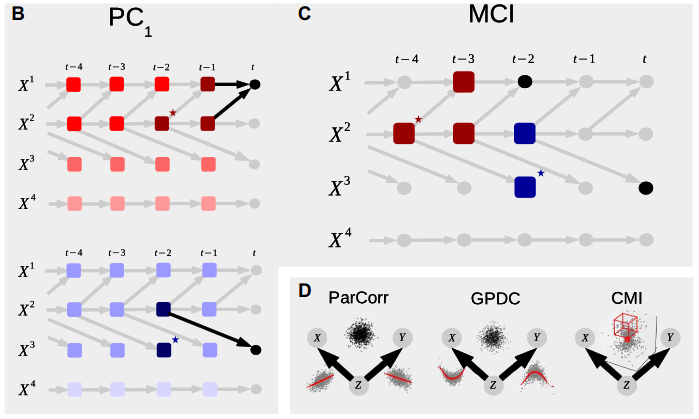

## (A) Causal discovery

In practice, causal inference often consists of two steps: 

(1) qualitative **causal discovery** to learn a causal graph from observational data, typically done using constraint-based methods.

(2) quantitative **causal effect estimation** that uses the resulting causal graph. The second step can also be achieved with e.g. an expert-informed Structural Causal Model (SCM) as basis.

This worksheet is structured as follows: in part (A), we will focus on causal discovery while introducing a few basic features of the `tigramite` Python package and PCMCI. In part (B), we apply PCMCI to learn causal networks from, firstly, observational sea level pressure data and, secondly, from equivalent data from a climate model simulation, following a dimension reduction step using PCA Varimax. This will motivate the topic of causal climate model evaluation. In part (C), we link to an optional tutorial on causal effect estimation from the `tigramite` tutorial website.

#### Recovering a toy model

To validate causal discovery methods, it is common to define toy model systems for a data-generating process. Using time series generated by this toy process, it should then be possible to recover the causal structure that generated the time series in the first place.

Let's try this here for the following linear data-generating process:

\begin{align*}
X^0_t &= 0.7 X^0_{t-1} - 0.8 X^1_{t-1} + \eta^0_t\\
X^1_t &= 0.8 X^1_{t-1} + 0.8 X^3_{t-1} + \eta^1_t\\
X^2_t &= 0.6 X^2_{t-1} + 0.6 X^1_{t-2} + 0.3 X^3_{t-3} + \eta^2_t\\
X^3_t &= 0.8 X^3_{t-1} + \eta^3_t\\
\end{align*}

where $\eta$ are independent zero-mean unit variance random variables. Our goal is to reconstruct the drivers of each variable. 

**Task 1** In `tigramite` such a process can be generated with the function ``toys.structural_causal_process`` using the alias `toys` defined above. The function requires a definition of the linkages among the variables as well as a function definition for each link. Below we have started with the definition of the links for the first two random variables in `links_coeffs`. *Copy this code and extend it with the corresponding definitions for the second and third variables.*

Afterwards, we use these links to build a `tigramite` dataframe object for later processing and data visualization.

In [ ]:
# Fix random seed
seed = 42
np.random.seed(seed)
def lin_f(x): return x
links_coeffs = {0: [((0, -1), 0.7, lin_f), ((1, -1), -0.8, lin_f)],
                1: [((1, -1), 0.8, lin_f), ((3, -1), 0.8, lin_f)],
               }
# YOUR CODE HERE
raise NotImplementedError()

# length of time series to be created
T = 1000
# generate the time series from the defined equations
data, _ = toys.structural_causal_process(links_coeffs, T=T, seed=seed)
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$']
dataframe = pp.DataFrame(data, 
                         datatime = {0:np.arange(len(data))}, 
                         var_names=var_names)

#### Data visualization

Next we visualize the data using `tigramite` plotting routines. As you will possibly notice, the data generation is by design stationary, which - unlike in many climate science examples - means we will automatically fulfill one of the assumptions underlying causal discovery methods.

In [ ]:
tp.plot_timeseries(dataframe)
plt.show()

In the following, to recover the causal structure, we will assume causal stationarity, no hidden variables, and only lagged dependencies, which is true given that we have defined the data-generating process ourselves. In reality, these assumptions might of course be at least mildly violated.

On the basis of these assumptions, we can use `PCMCI` for causal discovery. For both steps in PCMCI, we need to (a) choose a type of conditional independence test for constrained-based learning, and (b) hyperparameters such as the maximum time lag `tau_max` and significance thresholds for when the conditional independence is thought to be given.

Since we expect linear dependencies here, we can here choose the linear partial correlation `ParCorr` (imported above) conditional independence test. However, in principle non-linear tests can be used for this as well, such as CMIknn (for k-nearest neighbours) or GPDC (for Gaussian Process regression).

With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. 

Next, it's a good idea to plot the lagged unconditional dependencies, e.g., the lagged correlations using the ``ParCorr`` class. This can help to identify which maximal time lag ``tau_max`` to choose in the causal algorithm.
 
To this end, we initialize the ``PCMCI`` method with  ``dataframe``, and ``ParCorr`` as a ``cond_ind_test``. 

In [ ]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

Now we can calculate and visualize the lagged dependencies:

In [ ]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 'x_base':5, 'y_base':.5})
plt.show()

#### Causal discovery step with PCMCI

Here, since the dependencies in the lag function plot above decay beyond a maximum lag of around 8, we choose ``tau_max=8`` for PCMCI. The other main parameter is ``pc_alpha`` for the PC algorithm which sets the significance level in the condition-selection step, which is most critical for the number of tests considered for the causal graph in the first place (acts similar to a vacuum cleaner on all possible dimensions to be tested, to address the curse of dimensionality). Here we let PCMCI choose the optimal value by setting it to ``pc_alpha=None``. In this case, PCMCI will optimize this parameter in the ParCorr case by the [Akaike Information criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion) among a reasonable default list of values (e.g., `pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]`). Note that `pc_alpha` should not be considered as a significance test level in the condition-selection step since the iterative hypothesis tests in the PC-algorithm do not allow for a precise assessment. It rather takes the role of a regularization parameter in model-selection techniques.

The parameter ``alpha_level=0.01`` indicates that we threshold the resulting p-value matrix at this significance level to obtain the final causal graph that we recover from the data. 

Let's see what we get to in terms of causal discovery. So, next, we execute the `.run_pcmci()` method ([documentation](https://jakobrunge.github.io/tigramite/)) on the `pcmci` instance initialized on our dataframe above.

In [ ]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=8, pc_alpha=None, alpha_level=0.01)

**Task 2** Interpret the output. What happens in the PC step? What in the MCI step? Do we recover the original causal graph? If necessary, also refer to the original [documentation paper](https://www.science.org/doi/10.1126/sciadv.aau4996). Write your answer to `answer_task2`.

In [ ]:
answer_task2 = ''
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert len(answer_task2) > 0

The result of ``run_pcmci`` is a dictionary containing the matrix of p-values, the matrix of test statistic values (here MCI partial correlations) and optionally its confidence bounds (can be specified upon initializing ``ParCorr``), and the ``graph`` matrix indicating the links detected. ``p_matrix`` and ``val_matrix`` are of shape ``(N, N, tau_max+1)`` with entry $(i, j, \tau)$ denoting the test for the link $X^i_{t-\tau} \to X^j_t$.

The ``graph`` array of the same shape is obtained from thresholding the ``p_matrix`` at the specified ``alpha_level``. It is a string array and denotes significant lagged causal links by ``-->`` and contemporaneous links (where the orientation cannot be determined with PCMCI) by ``o-o``.

In [ ]:
results['graph']

In [ ]:
print("p-values")
print (results['p_matrix'].round(3))
print("MCI partial correlations")
print (results['val_matrix'].round(2))

#### Process graph visualization

Finally, we can visualize the results in a process graph. The node color denotes the auto-MCI value (i.e. autocorrelation) and the link colors the cross-MCI (i.e. here partial correlation) value. If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength. Additionally, setting `show_autodependency_lags=True` displays the significant auto-dependencies below the respective node labels.

In [ ]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    show_autodependency_lags=True
    ); plt.show()

While the process graph is nicer to look at, the time series graph better represents the spatio-temporal dependency structure from which causal pathways can be read off.

In [ ]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

## (B) Application example: causal climate model evaluation

#### Background

As noted several times in the lectures and previous exercises, atmospheric dynamical phenomena are often characterized using variables such as sea level pressure (SLP).

SLP fields can be used to characterize the dynamical state of the global atmosphere with its many coupled large-scale weather systems. Given that the atmosphere is a fluid, driven by radiative heating within and by heating/cooling from the lower land/ocean boundary, there are also so-called [teleconnections](https://www.weather.gov/fwd/teleconnections) that couple weather systems worldwide. Information is for example propagated rapidly through [Rossby waves](https://www.climate.gov/news-features/blogs/enso/what-are-teleconnections-connecting-earths-climate-patterns-global). Among others, these dynamical coupling effects modulate global rainfall patterns.

Here, you will run through a multi-step procedure to use PCMCI for the evaluation of global dynamical coupling mechanisms in the German climate model [MPI-ESM-MR](https://www.dkrz.de/en/communication/climate-simulations/cmip5-ipcc-ar5/das-modell-en?set_language=en):

1) First, you will use Singular Value Decomposition (SVD) to dimension-reduce standard-scaled gridded SLP data from the [NCEP-NCAR-reanalysis-I](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html) from 1979-2017. Reanalysis data serves as a good proxy for historical Earth observations, see e.g. the following [info website](https://www.ecmwf.int/en/about/media-centre/focus/2023/fact-sheet-reanalysis#:~:text=Reanalysis%20data%20provide%20the%20most,as%20'maps%20without%20gaps'.) by the ECMWF. This will result in a principal component analysis in which you retain the 100 components representing the maximum fraction of variance during the Northern Hemisphere winter season (i.e. December, January, February; abbreviated "DJF").

2) You will then apply a Varimax rotation to these components in order to "localize" them in space, leading to rotated components that represent more interpretable modes of climate variability.

3) Among the leading modes, you will then learn causal interaction networks using PCMCI. You will have applied the PCA Varimax transformation learned from the reanalysis data to equivalent data from a climate model simulation that was conducted with the German climate model MPI-ESM-MR. For a first comparison of the *observed* and *modelled* causal interactions, you will then use `tigramite` to visualize the two causal networks. Finally, you will interpret your results.

#### Load and pre-process the data

We will load daily average SLP data from the reanalysis and the climate model. For simplicity, we have already linearly de-trended the data (to make it approximately stationary) and coarsened their resolution to 5$\degree$ latitude $\times$ 5$\degree$ longitude horizontal resolution using [cdo operators](https://code.mpimet.mpg.de/projects/cdo/).

In [ ]:
### load SLP datasets for the reanalysis ("obs")
### and the climate model ("MPI")
ds_obs = xr.open_dataset('./data/SLP_ncar_01-01-1979_31-12-2017_detrend_5x5.nc')
ds_MPI = xr.open_dataset('./data/psl_day_MPI-ESM-MR_r1i1p1_19790101-20171231_detrend_regridded_1member_5x5.nc')
print(ds_obs['slp'].data.shape)
print(ds_MPI['psl'].data.shape)
print(ds_obs.time)
print(ds_MPI.time)
nr_lat = ds_obs.slp.data.shape[1]
nr_lon = ds_obs.slp.data.shape[2]

---
Let's visualize the first timestep in the observations:

---

In [ ]:
fig = plt.figure(figsize=(6,3))
lon_idx = ds_obs.slp.dims.index('lon')
levels = np.arange(-2000,2000,100)
lon = ds_obs.lon
lat = ds_obs.lat
wrap_slp, wrap_lon = add_cyclic_point(ds_obs.slp.data,coord=lon,axis=lon_idx)
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
cont = plt.contourf(wrap_lon,lat,wrap_slp[0,:,:],levels,transform=proj,cmap='bwr',extend='both')
cb = plt.colorbar(cont,ax=ax)
cb.set_label('Pa',size=12)
plt.title('SLP detrended 1st January 1979',size=12)
ax.coastlines()
ax.set_global()
ax.set_xticks([-150, -90, -30, 0, 30, 90, 150], crs=proj)
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

---
The next **pre-processing steps** (already done for you) are to:

(a) **Calculate anomalies** relative to the seasonal cycle and **scale** each grid point feature **by its standard deviation.**

(b) **Weight each grid location by the $\sqrt{(cos(latitude))}$** because of the different grid cell areas on a regular lat-lon grid. This type of weighting is appropriate here because PCA optimization concerns the square of the grid values.

(c) Finally, we **select days from DJF** only before learning seasonally-dependent PCA Varimax components.

*Read through the code and try to understand each step and what the final datasets represent.*

---

In [ ]:
### a simplistic method to subtract the daily average values 
### (you can certainly come up with better ways)
def deseasonalization(ds):
    daily_climatology = ds.groupby('time.dayofyear').mean(dim='time')
    window_size=10
    ### make sure the circular nature of the data is recognized when taking the rolling mean
    daily_climatology_circular = xr.concat([daily_climatology.isel(dayofyear=slice(-window_size//2, None)),
                        daily_climatology,
                        daily_climatology.isel(dayofyear=slice(None, window_size//2))],
                        dim='dayofyear')
    # smooth the daily data for the climatology, because it is noisy
    daily_climatology_circular = daily_climatology_circular.rolling(dayofyear=10,center=True,min_periods=1).mean()
    daily_climatology = daily_climatology_circular.isel(dayofyear=slice(window_size//2,-window_size//2))
    # Subtract the daily climatology from the original data to get deseasonalized data
    ds_deseasonalized = ds - daily_climatology.sel(dayofyear=ds.time.dt.dayofyear)
    return ds_deseasonalized
    
### deaseasonalize and then divide by the respective standard deviation
ds_obs_anom = deseasonalization(ds_obs)
ds_obs_anom.slp.data = ds_obs_anom.slp.data/np.std(ds_obs_anom.slp.data,axis=0)
ds_MPI_anom = deseasonalization(ds_MPI)
ds_MPI_anom.psl.data = ds_MPI_anom.psl.data/np.std(ds_MPI_anom.psl.data,axis=0)
### define latitude-dependent weights, then apply the weighting
lat = ds_obs.lat
cos_weights = np.empty((nr_lat,nr_lon))
for lat_idx in range(len(lat)):
    cos_weights[lat_idx,:] = math.cos(lat[lat_idx]*math.pi/180)**0.5
ds_obs_anom.slp.data = ds_obs_anom.slp.data*cos_weights
ds_MPI_anom.psl.data = ds_MPI_anom.psl.data*cos_weights
### create and apply mask for DJF only
mask = (ds_obs_anom['time.month'] == 12) | (ds_obs_anom['time.month'] == 1) | (ds_obs_anom['time.month'] == 2)
ds_obs_anom_djf = ds_obs_anom.where(mask,drop=True)
# ds_MPI_anom_djf = ds_MPI_anom.where(mask,drop=True)

#### Step 1: SVD on reanalysis data

**Task 3** Using [scipy.svd](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html), carry out a singular value decomposition on the processed observational SLP data `ds_obs_anom_djf`. First, you will need to reshape the data to an array of shape (number_samples, nr_features). What is the fraction of variance explained by the first 8 or 100 components after sorting the eigenvectors by eigenvalue? Print those two numbers to screen.

*Hints*: you might find the following functions useful: `.reshape()`, `.argsort()`, `.diag()`, `.sum()`. For simplicity, set `full_matrices` in `svd()` to `False`.

In [ ]:
# Your solution to Task 3 goes here
# YOUR CODE HERE
raise NotImplementedError()

**Task 4** Create a `matplotlib` figure showing the first eight principal component time series (i.e. of the eight components representing the largest fractions of variance). However, instead of just applying the transformation to the same data for DJF, show time series if the transformation is applied to the original data for the entire year, i.e. apply the transformation to `ds_obs_anom`. 

Use formulae discussed in the lectures to reconstruct the PC time series. *Hint*: You might find `numpy.matmul()` helpful.

In [ ]:
# Your solution to Task 4 goes here
# YOUR CODE HERE
raise NotImplementedError()

**Task 5** Create a second figure, this time also using `cartopy`, which shows `contourf` spatial maps of the first 8 eigenvectors, again sorted by the associated variance explained (with land surface boundaries indicated on the maps underneath). Use sensible labels etc. You may reuse code from this and previous exercises.

*Hint*: You might find the following [website](https://kpegion.github.io/Pangeo-at-AOES/examples/multi-panel-cartopy.html) with `cartopy` multi-panel examples helpful.

In [ ]:
# Your solution to Task 5 goes here
# YOUR CODE HERE
raise NotImplementedError()

#### Step 2: Varimax rotation

**Task 6** Run through the following steps:

6.1 Apply the `Varimax()` function below to carry out the Varimax rotation on the eigenvectors you have calculated with SVD above (no need to understand the function in detail; just assume that it returns the rotated eigenvectors `np.dot(Phi,R)` and the rotation matrix `R`. Run this operation on the first `n_comps_rot = 100` components as assigned below. *If you are interested, experiment how your later results change if you were to change this number.*

6.2 Then, visualize your results as in Task 5, but this time for the rotated eigenvectors. You should find that the eigenvectors/components are now more spatially localized, especially if you adjust the relative scale of your chosen colorbar. In meteorology and climate science, these are also often referred to as Rotated Empirical Orthogonal Functions (REOFs).

6.3 Finally, calculate new PC time series for the rotated components from the full time series, i.e. once again from `ds_obs_anom`. Assign these to the already initialized variable `rotated_PCs_obs`. These component-wise time series you will use as the basis for the causal networks below. In addition, run the same transformation on the climate model data to obtain the equivalent dimension-reduced data `rotated_PCs_MPI`, i.e. on `ds_MPI_anom`.

If you cannot complete these sub-steps, we will provide replacement data for `rotated_PCs_obs` and `rotated_PCs_MPI` below, for later use in Step 3.

In [ ]:
def varimax(Phi, gamma = 1.0, q = 1000,
    rtol = np.finfo(np.float32).eps ** 0.5,
    verbosity=0):
    p,k = Phi.shape
    R = np.eye(k)
    d=0
    # print Phi
    for i in range(q):
        if verbosity > 1:
            if i % 10 == 0.:
                print("\t\tVarimax iteration %d" % i)
        d_old = d
        Lambda = np.dot(Phi, R)
        u,s,vh = np.linalg.svd(np.dot(Phi.T,np.asarray(Lambda)**3
                   - (gamma/float(p)) * np.dot(Lambda,
                    np.diag(np.diag(np.dot(Lambda.T,Lambda))))))
        R = np.dot(u,vh)
        d = np.sum(s)
        if d_old!=0 and abs(d - d_old) / d < rtol: break
    # print i
    return np.dot(Phi, R), R

# Your solution to Task 6.1 goes here:
n_comps_rot = 100
Vr = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Your solution to Task 6.2 goes here:
# visualize the rotated eigenvectors using cartopy surface maps
# you might want to adjust the colorbar range to the new max absolute value
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Your solution to Task 6.3 goes here:
# use the rotated eigenvectors to calculate the time series for the REOFs
# print the shape of the resulting matrices (n_samples,n_comps) to screen
rotated_PCs_obs = None
rotated_PCs_MPI = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert Vr is not None
assert rotated_PCs_obs is not None
assert rotated_PCs_MPI is not None

#### Step 3: PCMCI to reconstruct causal networks

Now, it's time to run PCMCI on these rotated component time series. The resulting causal networks will represent causal interpretations of atmospheric dynamical interactions among the localized modes of climate variability, i.e. how one mode is coupled to another, e.g. through Rossby wave trains. As a few more pre-processing steps, we will use three-day averages of the component time series and select DJF data again using `tigramite` pre-processing routines. We will consider only the leading `n_comps_networks` = 15 components in the causal networks, primarily for computational reasons. You may experiment with this number, especially larger numbers of components, if you like. 

As in part (A) for the toy example, we will turn the time series of the REOFs for the observations and the climate model into two dataframes whose components are labelled ['1','2','3', ... ]. 

If you could not complete **Task 6.3** above, uncomment the next cell first to load an example set of REOF time series, which we have saved for you in the data folder.

In [ ]:
# rotated_PCs_obs = np.load('./data/rotated_PCs_obs.npy')
# rotated_PCs_MPI = np.load('./data/rotated_PCs_MPI.npy')

In [ ]:
# let's do the necessary data pre-processing to bring the data into the shape we want for tigramite 
# see also Tigramite data processing: 
# https://jakobrunge.github.io/tigramite/_modules/tigramite/data_processing.html
# We will construct the networks on the leading 15 components here, mainly for computational reasons
# feel free to experiment with higher numbers if you like
n_comps_networks = 15
# first we take three-day averages of the daily data. This is a way to speed up computations slightly 
# while considering relatively long lags
# below we will consider 5 lags, i.e. up to 15 days into the past
rotated_PCs_obs_3dm = pp.time_bin_with_mask(rotated_PCs_obs, time_bin_length=3)[0]
rotated_PCs_MPI_3dm = pp.time_bin_with_mask(rotated_PCs_MPI, time_bin_length=3)[0]
mask_3dm = pp.time_bin_with_mask(mask.data,time_bin_length=3)[0]
mask_reshaped = np.tile(mask_3dm[:,np.newaxis],(1,n_comps_networks))
var_names = [str(i) for i in range(1, n_comps_networks+1)]
print(var_names)
dataframe_obs = pp.DataFrame(rotated_PCs_obs_3dm[:,:n_comps_networks],var_names=var_names,mask=mask_reshaped)
dataframe_MPI = pp.DataFrame(rotated_PCs_MPI_3dm[:,:n_comps_networks],var_names=var_names,mask=mask_reshaped)

**Task 7** Now it is your task to run PCMCI on the two dataframes, individually. The result will be two causal networks representing the coupling between the modes of variability under consideration, one for the reanalysis/observations and one for the climate model.

For this, assume linear relationships for the coupling among the climate modes und define two separate instances of `ParCorr()` objects, one for the observations and one the MPI climate model, respectively. Then combine these with two different `PCMCI()` instances, as done for the toy example in part (A). Finally, run both calculations using `.run_pcmci()`: in both cases choose `tau_max` = 5, `pc_alpha`= None, and an `alpha_level` for the MCI significance test of $10^{-4}$. The latter very small value partly acknowledges the challenges of [multiple hypothesis testing](https://towardsdatascience.com/why-and-how-to-adjust-p-values-in-multiple-hypothesis-testing-2ccf174cdbf8) and its connection to $p$-values. If you want to avoid long output for from `.run_pcmci()`, set its `verbosity` = 0.

All this might take a few minutes to run...time for a coffee...sparkling water...?

Save the results of your PCMCI runs to the already initialized variables `results_obs` and `results_MPI`.

In [ ]:
# Your solution to Task 7 goes here:
results_obs = None
results_MPI = None
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert results_obs is not None
assert results_MPI is not None

---
Let's now have a look at the resulting causal networks, first for the observations network and then for the German climate model.

Just run the prepared visualization cell below.

---

In [ ]:
print()
print('Plot of the observations network:')
results=results_obs
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
vmin=-np.amax(results['val_matrix'])
vmax=np.amax(results['val_matrix'])
tp.plot_graph(
    results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    label_fontsize=10,
    link_label_fontsize=8,
    # figsize=(10, 10),
    vmin_edges=vmin,
    vmax_edges=vmax,
    vmin_nodes=0.2,
    vmax_nodes=0.7,
    node_size=0.3,
    arrowhead_size=20,
    arrow_linewidth=3.0,
    edge_ticks=0.4,
    node_ticks=0.4,
    node_label_size=11,
    alpha=0.6,
    cmap_nodes='Oranges',
    cmap_edges='RdBu_r',
    );
plt.show()
print()
print('Plot of the climate model network:')
results=results_MPI
vmin=-np.amax(results['val_matrix']); vmax=np.amax(results['val_matrix']); tp.plot_graph(results['graph'],val_matrix=results['val_matrix'],var_names=var_names,link_colorbar_label='cross-MCI', node_colorbar_label='auto-MCI',
    label_fontsize=10, link_label_fontsize=8, vmin_edges=vmin, vmax_edges=vmax, vmin_nodes=0.2, vmax_nodes=0.7, node_size=0.3, arrowhead_size=20,
    arrow_linewidth=3.0, edge_ticks=0.4, node_ticks=0.4, node_label_size=11, alpha=0.6,cmap_nodes='Oranges', cmap_edges='RdBu_r',); plt.show()

**Task 8** According to a visual inspection of the climate model network - in your opinion, does it do a good job in terms of reproducing the observed atmospheric dynamical network, according to this causal network representation? Make a couple of suggestions of how you would go about a more systematic comparison of the climate model network to the observational network. Write your answer to `answer_task8`.

In [ ]:
answer_task8 = ''
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert len(answer_task8) > 0

## (C) *(Optional)* Causal effect estimation

The test statistic values (e.g., partial correlation) may give a qualitative intuition of the strength of a dependency, but for a proper causal effect analysis we need to e.g. use the causal effect framework by Pearl (2009). While a detailed treatment of these ideas is beyond the scope of this module, a few of you might be interested in a deeper exploration of the general topic. If so, we recommend the [linked Jupyter-notebook](https://github.com/jakobrunge/tigramite/blob/master/tutorials/causal_effect_estimation/tigramite_tutorial_general_causal_effect_analysis.ipynb) on Causal Effect Analysis, which forms part of the `tigramite` tutorials. 